In [1]:
import numpy as np
import matplotlib.pyplot as plt
import starry

import exoplanet as exo


In [2]:
starry.__version__

'1.0.0.dev3'

In [3]:
map = starry.Map(ydeg=20, udeg=2, rv=True, lazy=False)


In [5]:
time, vels, verr = np.loadtxt('../data/transit.vels', usecols=[0,1,2], unpack=True)
time -= 2458706.5

In [6]:
Prot = 2.85             # days
P = 8.1387              # days
t0 = 0.165
e = 0.0                   
w = 0.0
inc = 82.0


vsini = 18.3 * 1e3      # m /s
r = 0.05972             # In units of Rstar
b = -0.40               # I want it to transit in the South!
a = 19.42               # In units of Rstar
u1 = 0.95
u2 = 0.20
obl = 10
gamma = -6
gammadot = 100

veq = vsini / np.sin(inc * np.pi / 180.0)



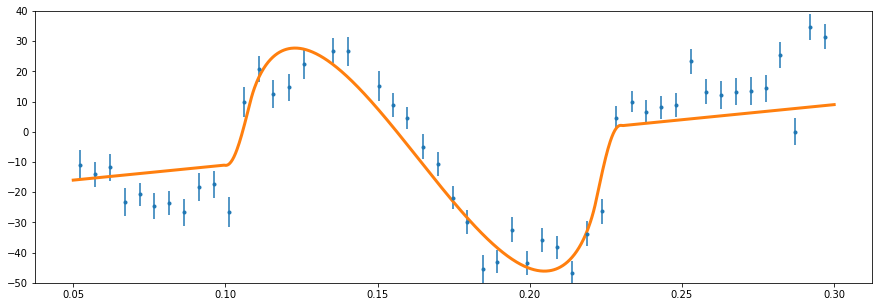

In [8]:
map.reset()
map.inc = inc
map.obl = obl
#map.add_spot(spot_amp, sigma=spot_sig, lon=spot_lon, lat=-spot_lat)
map[1:] = [u1, u2]
map.veq = veq

orbit = exo.orbits.KeplerianOrbit(period=P, a=a, t0=t0, b=b, ecc=e, omega=w, r_star=1.0) 


t = np.linspace(0.05, 0.30, 1000)
x, y, z = orbit.get_relative_position(t)
xo = x.eval()
yo = y.eval()
zo = z.eval()
theta = 360.0 / Prot * t

rv = map.rv(xo=xo, yo=yo, zo=zo, ro=r, theta=theta)
rv += gamma + gammadot*(t-0.15)

plt.figure(figsize=(15,5))
plt.plot(t, rv, "C1", lw=3)
plt.errorbar(time, vels, yerr=verr, fmt='.')
plt.ylim(-50, 40);

Compiling `render`... Done.


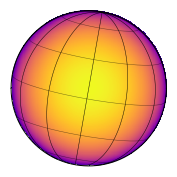

In [9]:
map.show(rv=False)

In [10]:
from scipy.optimize import minimize

In [109]:
tuse = time + 0.0
euse = verr + 0.0
vuse = vels + 0.0


def rmcurve(params):
    
    vsini, r, b, a, u1, u2, obl, gamma, gammadot, jitter_good, jitter_bad, q = params
    veq = vsini / np.sin(inc * np.pi / 180.0)

    map.reset()

    map.inc = inc
    map.obl = obl
    #map.add_spot(spot_amp, sigma=spot_sig, lon=spot_lon, lat=-spot_lat)
    map[1:] = [u1, u2]
    map.veq = veq

    vsini, r, b, a, u1, u2, obl, gamma, gammadot, jitter_good, jitter_bad, q = params
    veq = vsini / np.sin(inc * np.pi / 180.0)
    
    f = (tuse - t0)/P*2*np.pi
    I = np.arccos(b/a)

    zo = a*np.cos(f) 
    yo = -a*np.sin(np.pi/2+f)*np.cos(I)
    xo = a*np.sin(f)*np.sin(I)


    theta = 360.0 / Prot * tuse

    rv = map.rv(xo=xo, yo=yo, zo=zo, ro=r, theta=theta)
    rv += gamma + gammadot*(tuse-0.15)
    
    
    var_good = (euse**2 + jitter_good**2)
    var_bad  = (euse**2 + jitter_bad**2)
    gooddata = -0.5*q*(np.sum((rv-vuse)**2/var_good + np.log(2*np.pi*var_good)))
    baddata  = -0.5*(1-q)*(np.sum((rv-vuse)**2/var_bad + np.log(2*np.pi*var_bad)))
    lnprob = gooddata + baddata

    print(-1*lnprob)
    return -1*lnprob



In [114]:
def plot_rmcurve(params):

    vsini, r, b, a, u1, u2, obl, gamma, gammadot, jitter_good, jitter_bad, q = params
    veq = vsini / np.sin(inc * np.pi / 180.0)

    map.reset()

    map.inc = inc
    map.obl = obl
    #map.add_spot(spot_amp, sigma=spot_sig, lon=spot_lon, lat=-spot_lat)
    map[1:] = [u1, u2]
    map.veq = veq

    vsini, r, b, a, u1, u2, obl, gamma, gammadot, jitter_good, jitter_bad, q = params
    veq = vsini / np.sin(inc * np.pi / 180.0)
    
    f = (t - t0)/P*2*np.pi
    I = np.arccos(b/a)

    zo = a*np.cos(f) 
    yo = -a*np.sin(np.pi/2+f)*np.cos(I)
    xo = a*np.sin(f)*np.sin(I)

    theta = 360.0 / Prot * t

    rv = map.rv(xo=xo, yo=yo, zo=zo, ro=r, theta=theta)
    rv += gamma + gammadot*(t-0.15)

    plt.figure(figsize=(15,5))
    plt.plot(t, rv, "C1", lw=3)
    plt.errorbar(time, vels, yerr=verr, fmt='.')
    plt.ylim(-50, 40);
    plt.show()


In [110]:
inputs = np.array([18300, 0.0588, -0.09, 20.79, 1.0, 0.00, 13.15, -9.3, 200.1, 1.0, 10.0, 0.8])

bnds = ((12000, 24000), (0.04, 0.07), (-1.0, 0.0), (15,25), (0,1),(0,1), (0,90), (-20,20),(50,300), (0.0, 2.0), (2.0, 20.0), (0.0, 1.0))
rmcurve(inputs)

191.4952286412622


/Users/bmontet/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


191.4952286412622

In [111]:
res = minimize(rmcurve, inputs, method='L-BFGS-B', bounds=bnds)

191.4952286412622
191.49522864127823
191.49523924007352
191.495228174739
191.49522861899254
191.49522855438147
191.49522866000905
191.49522864396917
191.49522864396945
191.49522864176947
191.49522859971106
191.4952286450835
191.4952288432883
208.9438265846201
208.94382658459324
208.94380217658625
208.9438265339228
208.94382661366996
208.9438266432919
208.94382662651302
208.94382658658122
208.9438265853902
208.94382658620282
208.9438265846201
208.94382654291277
208.94382813911233
190.04659680089412
190.04659680086561
190.0465789013519
190.04659614277278
190.04659686740166
190.046596899701
190.04659693405378
190.04659680584632
190.04659680486833
190.0465968024062
190.04659675892253
190.04659680659515
190.04659701241644
188.72567898488708
188.72567898487384
188.7256710909843
188.72567839234284
188.72567904632513
188.72567909267036
188.7256791340542
188.72567898861553
188.7256789872381
188.72567898606133
188.72567894484783
188.72567899076813
188.7256791814233
187.97777118619467
187.9777711

175.33298763587524
175.33298764288634
175.33298764098885
175.33298764295574
175.3329876427153
175.33298766054767
175.33298784060503
175.24576077457064
175.24576077456712
175.24575856311642
175.24576071335363
175.24576079235214
175.2457607436779
175.2457607726598
175.24576077483133
175.24576077288492
175.24576077483982
175.24576077457064
175.24576079252668
175.24576097046454
175.04360207403613
175.04360207403116
175.0435989223095
175.04360201288193
175.04360209279167
175.04360205692495
175.04360208146713
175.0436020744044
175.0436020723939
175.04360207434146
175.04360207403613
175.04360209230197
175.0436022649543
174.6988891968982
174.6988891968925
174.69888562308975
174.69888913582454
174.69888921481171
174.698889198577
174.69888921673808
174.6988891973165
174.69888919525135
174.69888919722104
174.6988891968982
174.69888921573883
174.6988893786343
175.36954407855305
175.36954407854577
175.3695393686521
175.36954400876988
175.36954405721292
175.3695439988109
175.36954402831122
175.36954

169.8403317780679
169.84033177806685
169.84033132262175
169.84033170462945
169.84033176869102
169.84033173235392
169.84033176362468
169.84033177813998
169.8403317688597
169.84033177836815
169.8403317780679
169.8403317771047
169.84033193363595
169.4949919191256
169.49499191912457
169.49499149282752
169.49499180400971
169.49499191295592
169.49499187973294
169.4949919101008
169.49499191919887
169.49499191393122
169.49499191955917
169.4949919191256
169.4949919163389
169.49499206788678
169.32982683395943
169.32982683396082
169.3298279872469
169.32982667614846
169.3298268279575
169.32982680553096
169.3298268335809
169.32982683385399
169.32982683390873
169.32982683446954
169.32982683395943
169.3298268336085
169.32982697977286
169.30529231041257
169.30529231041183
169.30529203983986
169.30529215336406
169.3052923114201
169.30529228639256
169.30529231123376
169.3052923104687
169.30529231042772
169.30529231095545
169.30529231041257
169.30529231024292
169.30529245649151
169.30415209422785
169.304

In [112]:
# vsini, r, b, a, u1, u2, obl, gamma, gammadot = params
print(res.x.tolist())

[18299.98136796374, 0.05445371522033198, 0.0, 19.651691308110173, 1.0, 0.5146262091251679, 7.916350858538484, -8.529197173867448, 185.92720129079422, 2.0, 6.1992539810816165, 0.0]


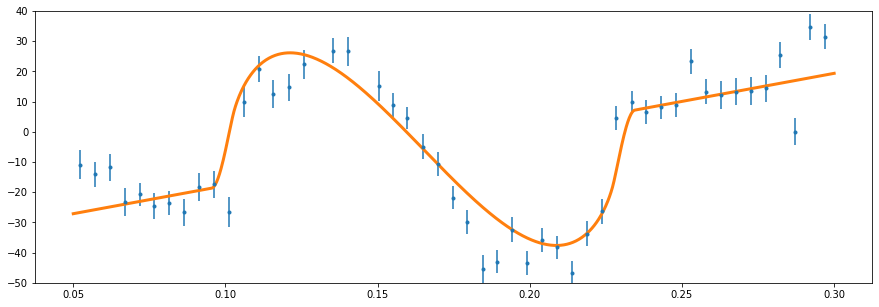

In [118]:
test = res.x + 0.0
#test[0] = 20000
test[4] = 1.0
test[5] = 0.0
plot_rmcurve(test)

In [81]:
orbit = exo.orbits.KeplerianOrbit(period=P, a=a, t0=t0, b=0.4, ecc=e, omega=w, r_star=1.0) 

x, y, z = orbit.get_relative_position(tuse)


In [82]:
xp = x.eval()
yp = y.eval()
zp = z.eval()

In [83]:
(zp**2+yp**2+xp**2)**0.5

array([19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42,
       19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42,
       19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42,
       19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42,
       19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42,
       19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42,
       19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42,
       19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42,
       19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42])

In [84]:
a

19.42

In [85]:
tuse = np.arange(-4, 4, 0.1)

f = (tuse - t0)/P*2*np.pi
I = np.arccos(b/a)


In [106]:


zpos = a*np.cos(f) 
ypos = -a*np.sin(np.pi/2+f)*np.cos(I)
xpos = a*np.sin(f)*np.sin(I)

In [108]:
zpos-zp

array([-4.10861147e-03, -4.11988110e-03, -4.10660824e-03, -4.06887196e-03,
       -4.00689705e-03, -3.92105270e-03, -3.81185031e-03, -3.67994039e-03,
       -3.52610875e-03, -3.35127177e-03, -3.15647097e-03, -2.94286680e-03,
       -2.71173171e-03, -2.46444261e-03, -2.20247260e-03, -1.92738228e-03,
       -1.64081037e-03, -1.34446401e-03, -1.04010856e-03, -7.29557091e-04,
       -4.14659590e-04, -9.72919255e-05,  2.20655316e-04,  5.37288094e-04,
        8.50720200e-04,  1.15908449e-03,  1.46054402e-03,  1.75330295e-03,
        2.03561731e-03,  2.30580532e-03,  2.56225745e-03,  2.80344598e-03,
        3.02793415e-03,  3.23438464e-03,  3.42156763e-03,  3.58836804e-03,
        3.73379223e-03,  3.85697389e-03,  3.95717923e-03,  4.03381130e-03,
        4.08641361e-03,  4.11467280e-03,  4.11842052e-03,  4.09763446e-03,
        4.05243843e-03,  3.98310167e-03,  3.89003722e-03,  3.77379949e-03,
        3.63508091e-03,  3.47470783e-03,  3.29363561e-03,  3.09294292e-03,
        2.87382531e-03,  